# Multi-Label Classification

In [1]:
import pandas as pd
import numpy as np
import json
import nltk
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

# Dataset
We will be using the CMU Movie Summary Corpus open dataset for this notebook. This dataset contains a list of movies and their genres. We can exploit movie summaries for predicting movie genres. 

In [2]:
data_dir = '/dsa/data/DSA-8410/MovieSummaries/'

In [3]:

meta = pd.read_csv(data_dir+"movie.metadata.tsv", sep = '\t', header = None)
meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


## Set the proper column name for the dataframe.

In [4]:
# rename columns
meta.columns = ["movie_id","freebase_movie_id","movie_name",
                "release_date","revenue","runtime", "languages","countries","genre"]
meta.head()

,movie_id,freebase_movie_id,movie_name,release_date,revenue,runtime,languages,countries,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


# Load movie plots
The movie plot is in a different file. We need to load the plot separately.

In [5]:
plots = []

with open(data_dir + "plot_summaries.txt", 'r') as f:
       reader = csv.reader(f, dialect='excel-tab') 
       for row in tqdm(reader):
            plots.append(row)
            
movie_id = []
plot = []

# extract movie Ids and plot summaries
for i in tqdm(plots):
  movie_id.append(i[0])
  plot.append(i[1])

# create dataframe
movies = pd.DataFrame({'movie_id': movie_id, 'plot': plot})
movies.head()

42303it [00:03, 11695.78it/s]
100%|██████████| 42303/42303 [00:00<00:00, 594629.99it/s]


,movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole..."
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e..."
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo..."
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r..."


# Data Exploration and Pre-processing
Now add the meta information to the movies dataframe. 

In [6]:

# change datatype of 'movie_id'
meta['movie_id'] = meta['movie_id'].astype(str)

# merge meta with movie plots
movies = pd.merge(movies, meta[['movie_id', 'movie_name', 'genre']], on = 'movie_id')

movies.head()

,movie_id,plot,movie_name,genre
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all.",Taxi Blues,"{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World cinema""}"
1,31186339,"The nation of Panem consists of a wealthy Capitol and twelve poorer districts. As punishment for a past rebellion, each district must provide a boy and girl between the ages of 12 and 18 selected by lottery for the annual Hunger Games. The tributes must fight to the death in an arena; the sole...",The Hunger Games,"{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama""}"
2,20663735,"Poovalli Induchoodan is sentenced for six years prison life for murdering his classmate. Induchoodan, the only son of Justice Maranchery Karunakara Menon was framed in the case by Manapally Madhavan Nambiar and his crony DYSP Sankaranarayanan to take revenge on idealist judge Menon who had e...",Narasimham,"{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action"", ""/m/07s9rl0"": ""Drama"", ""/m/01chg"": ""Bollywood""}"
3,2231378,"The Lemon Drop Kid , a New York City swindler, is illegally touting horses at a Florida racetrack. After several successful hustles, the Kid comes across a beautiful, but gullible, woman intending to bet a lot of money. The Kid convinces her to switch her bet, employing a prefabricated con. Unfo...",The Lemon Drop Kid,"{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""Comedy""}"
4,595909,"Seventh-day Adventist Church pastor Michael Chamberlain, his wife Lindy, their two sons, and their nine-week-old daughter Azaria are on a camping holiday in the Outback. With the baby sleeping in their tent, the family is enjoying a barbecue with their fellow campers when a cry is heard. Lindy r...",A Cry in the Dark,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama"", ""/m/01f9r0"": ""Docudrama"", ""/m/03q4nz"": ""World cinema"", ""/m/05bh16v"": ""Courtroom Drama""}"


In [7]:

movies['genre'][0]


'{"/m/07s9rl0": "Drama", "/m/03q4nz": "World cinema"}'

The tags are in json. We need to convert json to list

In [8]:
import pandas as pd
import json

# Load the movies dataset
movies = pd.read_csv('/dsa/data/DSA-8410/MovieSummaries/movie.metadata.tsv', sep='\t', header=None)

# Assign column names to the dataframe (if not already done)
movies.columns = ["movie_id", "freebase_movie_id", "movie_name", "release_date", "revenue", "runtime", "languages", "countries", "genre"]

# An empty list to store the genres
genres = []

# Extract genres
for i in movies['genre']:
    genres.append(list(json.loads(i).values()))

# Add the new genre list to the movies dataframe
movies['genre_new'] = genres

In [9]:
movies.head()

,movie_id,freebase_movie_id,movie_name,release_date,revenue,runtime,languages,countries,genre,genre_new
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}","[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}","[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","[Thriller, Erotic thriller, Psychological thriller]"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[Drama]


# T1. Drop movies which doesn't have any genre information

Dropping the movies which don't have any information about tags.

In [10]:
# remove samples with 0 genre tags
movies_new = movies[~(movies['genre_new'].str.len() == 0)]
movies_new.shape, movies.shape

((79447, 10), (81741, 10))

# List all genres

In [11]:
# get all genre tags in a list
all_genres = sum(genres,[])
len(set(all_genres))

363

There are around 363 genres. This is too many. To reduce computing load, we will use top 50 gneres for prediciton. 


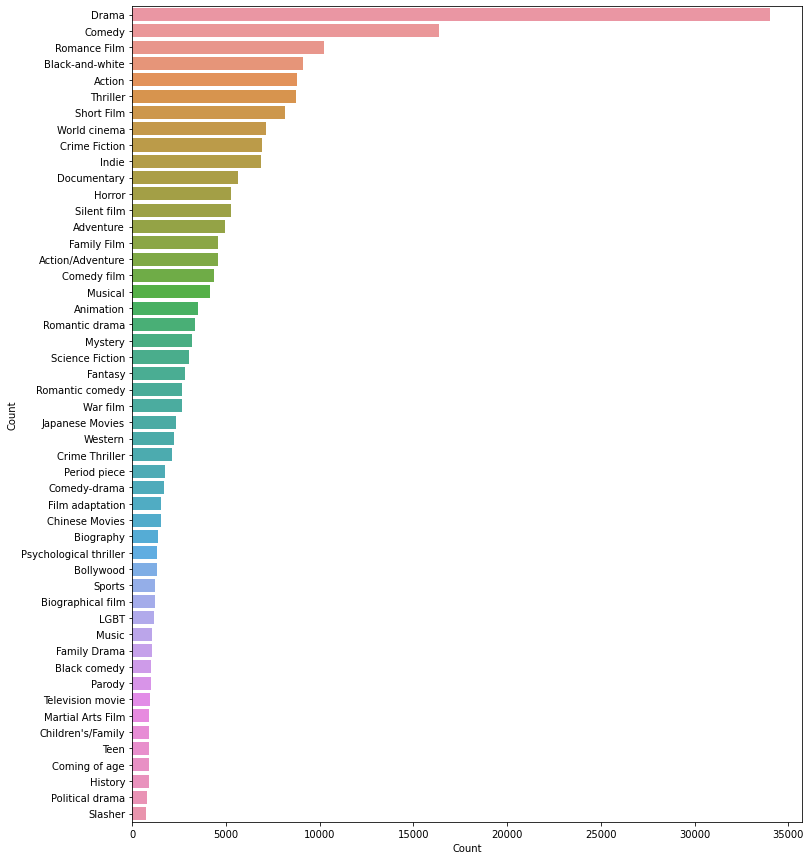

In [12]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})

g = all_genres_df.nlargest(columns="Count", n = 50) 

plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [13]:
selected_genre = list(g['Genre'])

# an empty list
tmp_genres = [] 

# extract genres
for i in movies['genre_new']: 
  tmp_genres.append(list(set(i).intersection(set(selected_genre)))) 

# add to 'movies' dataframe  
movies['chosen_genre'] = tmp_genres

movies.head()

,movie_id,freebase_movie_id,movie_name,release_date,revenue,runtime,languages,countries,genre,genre_new,chosen_genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]","[Thriller, Horror, Action, Science Fiction, Adventure]"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}","[Mystery, Biographical film, Drama, Crime Drama]","[Drama, Mystery, Biographical film]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}","[Crime Fiction, Drama]","[Drama, Crime Fiction]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","[Thriller, Erotic thriller, Psychological thriller]","[Thriller, Psychological thriller]"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[Drama],[Drama]


# T2. Drop rows that don't have any top-50 genres

We dropped the genres which are not in the top 50 list. So some movies now don't belong to any of these genres. We need to drop these movies. 

In [14]:
# remove samples with 0 genre tags


# T3. Clean the movie plot

This function drops the unnecessary characters from the movie plots. We will learn about regular expression later in this course. Use this function as a black box. 


In [15]:
# function for text cleaning 
def clean_text(text):
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    return text

Now, apply `clean_text` funciton in the dataframe to clean the plots.

In [22]:
movies_new['clean_movie_name'] = movies_new['movie_name'].apply(lambda x: clean_text(x))


# Check the clean plots now.

All the top words are the stopwords, which won't help in predicting the movie tags. So we need to drop them. A python package named `nltk` has a stop words remover. We will use that to drop all the stopwords from the plots.

In [23]:
movies_new.head()

,movie_id,freebase_movie_id,movie_name,release_date,revenue,runtime,languages,countries,genre,genre_new,chosen_genre,clean_movie_name
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]","[Thriller, Horror, Action, Science Fiction, Adventure]",ghosts of mars
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}","[Mystery, Biographical film, Drama, Crime Drama]","[Drama, Mystery, Biographical film]",getting away with murder the jonben t ramsey mystery
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}","[Crime Fiction, Drama]","[Drama, Crime Fiction]",brun bitter
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","[Thriller, Erotic thriller, Psychological thriller]","[Thriller, Psychological thriller]",white of the eye
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[Drama],[Drama],a woman in flames


# Plot a frequency distribution of words in all the plots and identify the most frequent words. 

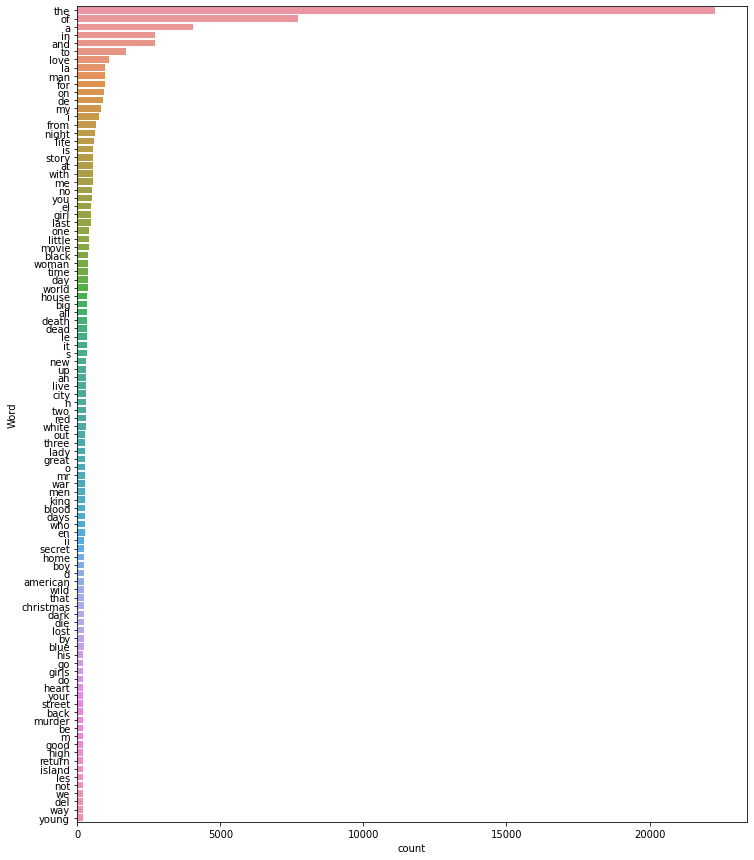

In [29]:

if 'clean_movie_name' not in movies_new.columns:
    movies_new['clean_movie_name'] = movies_new['movie_name'].apply(lambda x: clean_text(x))


def freq_words(x, terms=30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word': list(fdist.keys()), 'count': list(fdist.values())})

    # Select top n most frequent words
    d = words_df.nlargest(columns='count', n=terms)

    # Visualize words and frequencies
    plt.figure(figsize=(12,15))
    ax = sns.barplot(data=d, x='count', y='word')
    ax.set(ylabel='Word')
    plt.show()

# Print the 100 most frequent words
freq_words(movies_new['clean_movie_name'], 100)


# Remove stop words

Most of the frequent words are stop words. We will download the list of stop words from `nltk` library and remove them from plots. 

In [31]:
# download stopwords
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)

movies_new['clean_movie_name'] = movies_new['clean_movie_name'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to /home/djkgg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Inspect the plots after removing the stopwords.

In [32]:
movies_new.head()

,movie_id,freebase_movie_id,movie_name,release_date,revenue,runtime,languages,countries,genre,genre_new,chosen_genre,clean_movie_name
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}","[Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western]","[Thriller, Horror, Action, Science Fiction, Adventure]",ghosts mars
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}","[Mystery, Biographical film, Drama, Crime Drama]","[Drama, Mystery, Biographical film]",getting away murder jonben ramsey mystery
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}","[Crime Fiction, Drama]","[Drama, Crime Fiction]",brun bitter
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}","[Thriller, Erotic thriller, Psychological thriller]","[Thriller, Psychological thriller]",white eye
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[Drama],[Drama],woman flames


# Encoding target variables

We cannot use the text tags as targets directly in the model. We are required to convert the targets to multi-binary features. As we now have only 50 tags/genres, the number of target variables is 50. There is a 50-length output vector for each movie, where all the values will be zero except the corresponding movie tag position. 

In [33]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(movies_new['chosen_genre'])

# transform target variable
y = multilabel_binarizer.transform(movies_new['chosen_genre'])

In [34]:
y.shape

(81741, 50)

# Convert text to feature vector

We can't train the model directly from the text. We need to convert it to a numeric vector feature. To convert the text to a feature vector, we will use sklearn's `TfidfVectorizer`. This method converts a text data to a numeric vector.  

In [35]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=100)


# T4. Create train (80%) and test (20%) split

In [37]:
 xtrain, xval, ytrain, yval = train_test_split(movies_new['clean_movie_name'], y, 
                                              test_size=0.2, random_state=9)

# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)


# T5. Multi-label Model Training

As we have multiple outputs (i.e., genres) for each movie, we will be using `MultiOutputClassifier` as it can learn multiple targets simultaneously. Internally it learns a model (aka base model) for every target. Let's use a decision tree classifier as a base model.

In [40]:
from sklearn.model_selection import train_test_split

movies['clean_movie_name'] = movies['movie_name'].apply(clean_text)
print(movies.columns)
xtrain, xval, ytrain, yval = train_test_split(movies['clean_movie_name'], y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=100)
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier

clf = MultiOutputClassifier(DecisionTreeClassifier()).fit(xtrain_tfidf, ytrain)
y_pred = clf.predict(xval_tfidf)

Index(['movie_id', 'freebase_movie_id', 'movie_name', 'release_date',
       'revenue', 'runtime', 'languages', 'countries', 'genre', 'genre_new',
       'chosen_genre', 'clean_movie_name'],
      dtype='object')


# T6. Measure Accuracy

In [41]:
acc = np.sum(y_pred==yval) / (yval.shape[0]*yval.shape[1])
print(f"Acc: {acc:.2}")

Acc: 0.95


# T7. Qualitative evaluation: radnomly pick 10 plots, show their text, true genres, and predicted genres.

In [44]:
def infer_tags(q):
    q = clean_text(q)
    q = remove_stopwords(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)



for i in range(10): 
    k = xval.sample(1).index[0] 
    print("Movie: ", movies_new['movie_name'][k], "\nPredicted genre: ", 
        infer_tags(xval[k])), print("Actual genre: ",movies_new['genre_new'][k], "\n")

Movie:  The Danish Experience 
Predicted genre:  [()]
Actual genre:  ['Comedy film', 'Drama'] 

Movie:  The Careless Years 
Predicted genre:  [()]
Actual genre:  ['Romantic drama', 'Romance Film', 'Drama', 'Musical'] 

Movie:  Two A.M.; or, the Husband's Return 
Predicted genre:  [('Drama',)]
Actual genre:  ['Short Film', 'Silent film'] 

Movie:  The Man from Majorca 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Crime Fiction', 'Action'] 

Movie:  My Monster Mom 
Predicted genre:  [()]
Actual genre:  ['Drama', 'Comedy-drama', 'Comedy', 'World cinema', 'Filipino Movies'] 

Movie:  Lovers Vanished 
Predicted genre:  [()]
Actual genre:  ['Romance Film'] 

Movie:  Do Ankhen Barah Hath 
Predicted genre:  [()]
Actual genre:  ['Drama'] 

Movie:  The Fourth State 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Political thriller'] 

Movie:  Sold 
Predicted genre:  [()]
Actual genre:  ['Drama'] 

Movie:  Hot Rods to Hell 
Predicted genre:  [()]
Actual genre:  ['Thriller', 'Sports', 

# Save your notebook, then `File > Close and Halt`